Importo librerías necesarias


In [136]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objects as go
from plotly import tools
from sklearn.cluster import KMeans
from sklearn import datasets
import cufflinks as cf
import chart_studio.plotly

cf.go_offline()
chart_studio.tools.set_credentials_file(username='DemoAccount', api_key='lr1c37zw81')

# Exploración del archivo csv

In [137]:
#Leo el archivo csv
data = pd.read_csv('/home/alejandro/Descargas/data_test_bnext.csv')
data.head()

,user_id,amount,category,date
0,jcbvas-raczml-ghjpyi,7.500,Purchase,2018-12-01 07:58:39
1,nscvb-jlazc-kihpj,0.000,Purchase,2018-12-01 07:58:27
2,aavoq-mmzuy-yypqt,125.000,Topup TPV,2018-12-01 07:57:50
3,jjiiav-rrggmz-ggxxyp,845.000,Purchase,2018-12-01 07:57:46
4,nqsoc-jylua-ktiqh,1009.925,Topup TPV,2018-12-01 07:57:16


In [138]:
#Comprobando el tipo de dato por columna y el número de registros totales
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158693 entries, 0 to 158692
Data columns (total 4 columns):
user_id     158693 non-null object
amount      158693 non-null float64
category    158693 non-null object
date        158693 non-null object
dtypes: float64(1), object(3)
memory usage: 4.8+ MB


In [139]:
#Comprobando si hay valores nulls
data.isnull().sum()

user_id     0
amount      0
category    0
date        0
dtype: int64

In [140]:
# Observo el nº de usuarios distintos
user = data['user_id'].unique()
len(user)

38843

In [141]:
#Compruebo si hay valores negativos
data.amount.min()

0.0

In [142]:
'''
Comprobando el periodo de tiempo del dataset(10 días, porque los datos del día 1/12 no son representativos
ya que solo hay hasta las 8:00 de la mañana)
'''
print(data['date'].max())
print(data['date'].min())

2018-12-01 07:58:39
2018-11-20 07:59:18


In [143]:
#Quitamos las horas a la columna date para poder trabajar mejor.
data['date'] = pd.to_datetime(data['date']).dt.date;

# Pregunta nº 1 

PREGUNTA 1: La primera pregunta tiene que ver con los usuarios que han gastado en este periodo. ¿Se te ocurre alguna manera de agrupar a los usuarios en función de su valor? Explica por favor la razón de agruparlos de la manera elegida y los cálculos que has realizado para ello.

In [144]:
"""
Como nos piden que agrupemos a los usuarios en función de los gastos, solo utilizaré las categorías 'Purchase' y 
'Bnext send money', dejando a un lado los 'Topup TPV' (ingresos).
"""
gastos = data[data.category != 'Topup TPV']
gastos.head()

,user_id,amount,category,date
0,jcbvas-raczml-ghjpyi,7.500,Purchase,2018-12-01
1,nscvb-jlazc-kihpj,0.000,Purchase,2018-12-01
3,jjiiav-rrggmz-ggxxyp,845.000,Purchase,2018-12-01
5,ooqab-uuymc-qqtyj,10.000,Purchase,2018-12-01
6,oaqva-umyzm-qytpy,37.475,Purchase,2018-12-01


In [145]:
# Calculo el gasto total por cliente

gasto_total_cliente = pd.pivot_table(gastos, index = 'user_id', values = 'amount', aggfunc = ({'amount':sum}))
gasto_total_cliente = gasto_total_cliente.sort_values(by = ['amount'], ascending = False)
gasto_total_cliente.reset_index(inplace = True)
gasto_total_cliente.head()

,user_id,amount
0,qsqbs-ylycl-titji,125201.750
1,bbqij-ccygr-jjtxg,66192.475
2,jvjja-rzrrm-gpggy,58521.500
3,bcijo-cagru-jhxgq,51673.925
4,jicsc-rgala-gxhih,47597.500


In [146]:
# Calculo el nº de operaciones (charges) por clientes 

numero_gastos_clientes = pd.pivot_table(gastos, index = ['user_id'], values = 'amount', aggfunc = ({'amount': 'count'}))
numero_gastos_clientes = numero_gastos_clientes.sort_values(by = ['amount'],ascending = False)
numero_gastos_clientes.head()
numero_gastos_clientes = numero_gastos_clientes.rename(columns={'amount':'charges'})
numero_gastos_clientes.reset_index(inplace = True)
numero_gastos_clientes.head()

,user_id,charges
0,qsqbs-ylycl-titji,99
1,vocqa-zuaym-pqhty,70
2,avo-mzu-ypq,65
3,nncjs-jjarl-kkhgi,56
4,vcasn-zamlj-phyik,55


In [147]:
# Mergeo los resultados anteriores para poder tenerlo todo en la misma tabla y poder realizar más cálculos.

resultado = pd.merge(gasto_total_cliente, numero_gastos_clientes, on = 'user_id')
resultado.head()

,user_id,amount,charges
0,qsqbs-ylycl-titji,125201.750,99
1,bbqij-ccygr-jjtxg,66192.475,30
2,jvjja-rzrrm-gpggy,58521.500,13
3,bcijo-cagru-jhxgq,51673.925,36
4,jicsc-rgala-gxhih,47597.500,4


[[1.         0.30058184]
 [0.30058184 1.        ]]


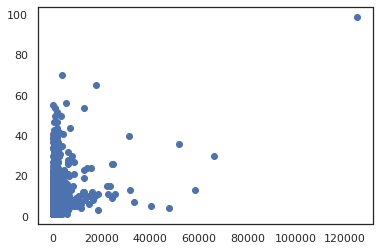

In [148]:
# Observo la correlación entre las variables gasto total por cliente y nº de gastos totales por cliente.
print(np.corrcoef(resultado['amount'], resultado['charges']))
plt.scatter(resultado['amount'],resultado['charges']);

#La correlación es baja lo que indica que las variables son independientes e indican datos distintos.

In [149]:
import plotly.express as px
iris = px.resultado.iris()
fig = px.scatter(iris, x="amount", y="charges")
fig.show()

ImportError: cannot import name 'qualitative'

In [150]:
#Calculo la primera fecha de gasto para cada uno de los clientes

datemin = pd.pivot_table(data, index = 'user_id', values = 'date', aggfunc = ({'date':min}))
datemin = datemin.rename(columns={'date':'min_date'})
datemin.reset_index(inplace = True)
datemin.head()

,user_id,min_date
0,aaaas-mmmml-yyyyi,2018-11-23
1,aaabb-mmmcc-yyyjj,2018-11-21
2,aaaca-mmmam-yyyhy,2018-11-22
3,aaaci-mmmag-yyyhx,2018-11-23
4,aaacn-mmmaj-yyyhk,2018-11-21


In [151]:
#Calculo la última fecha de gasto para cada uno de los clientes

datemax = pd.pivot_table(data, index = 'user_id', values = 'date', aggfunc = ({'date':max}))
datemax = datemax.rename(columns={'date':'max_date'})
datemax.reset_index(inplace = True)
datemax.head()

,user_id,max_date
0,aaaas-mmmml-yyyyi,2018-11-27
1,aaabb-mmmcc-yyyjj,2018-11-29
2,aaaca-mmmam-yyyhy,2018-11-27
3,aaaci-mmmag-yyyhx,2018-11-26
4,aaacn-mmmaj-yyyhk,2018-11-27


In [152]:
#Añado las tablas anteriores a la tabla general
fechas = pd.merge(datemin, datemax, on = 'user_id')
resultado_final = pd.merge(resultado, fechas, on = 'user_id')
resultado_final.head()

,user_id,amount,charges,min_date,max_date
0,qsqbs-ylycl-titji,125201.750,99,2018-11-22,2018-11-30
1,bbqij-ccygr-jjtxg,66192.475,30,2018-11-21,2018-12-01
2,jvjja-rzrrm-gpggy,58521.500,13,2018-11-21,2018-11-30
3,bcijo-cagru-jhxgq,51673.925,36,2018-11-20,2018-12-01
4,jicsc-rgala-gxhih,47597.500,4,2018-11-22,2018-11-29


In [153]:
'''
Cálculo el periodo de actividad para cada uno de los clientes (Última fecha gasto - Primera fecha gasto)
'''
resultado_final['Days between purchases'] = resultado_final['max_date'] - resultado_final['min_date'] 
resultado_final['Days between purchases']=resultado_final['Days between purchases']/np.timedelta64(1,'D')
resultado_final['Days between purchases'] = resultado_final['Days between purchases'] + 1
resultado_final.head()

,user_id,amount,charges,min_date,max_date,Days between purchases
0,qsqbs-ylycl-titji,125201.750,99,2018-11-22,2018-11-30,9.0
1,bbqij-ccygr-jjtxg,66192.475,30,2018-11-21,2018-12-01,11.0
2,jvjja-rzrrm-gpggy,58521.500,13,2018-11-21,2018-11-30,10.0
3,bcijo-cagru-jhxgq,51673.925,36,2018-11-20,2018-12-01,12.0
4,jicsc-rgala-gxhih,47597.500,4,2018-11-22,2018-11-29,8.0


In [154]:
#Para cada cliente calculo la media de 'gastos en función del nº gastos' y la 'media del número de gastos diarios'
resultado_final['Mean_by_charges(€)'] = resultado_final['amount']/resultado_final['charges']
resultado_final['Mean_daily_charge'] = resultado_final['charges']/resultado_final['Days between purchases']
resultado_final.head()

,user_id,amount,charges,min_date,max_date,Days between purchases,Mean_by_charges(€),Mean_daily_charge
0,qsqbs-ylycl-titji,125201.750,99,2018-11-22,2018-11-30,9.0,1264.664141,11.000000
1,bbqij-ccygr-jjtxg,66192.475,30,2018-11-21,2018-12-01,11.0,2206.415833,2.727273
2,jvjja-rzrrm-gpggy,58521.500,13,2018-11-21,2018-11-30,10.0,4501.653846,1.300000
3,bcijo-cagru-jhxgq,51673.925,36,2018-11-20,2018-12-01,12.0,1435.386806,3.000000
4,jicsc-rgala-gxhih,47597.500,4,2018-11-22,2018-11-29,8.0,11899.375000,0.500000


[[1.         0.00812085]
 [0.00812085 1.        ]]


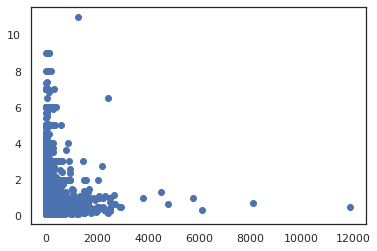

In [155]:
#Veo la correlación entre las variables 'gastos en función del nº gastos' y la 'media del número de gastos diarios'
plt.scatter(resultado_final['Mean_by_charges(€)'],resultado_final['Mean_daily_charge'])
print(np.corrcoef(resultado_final['Mean_by_charges(€)'], resultado_final['Mean_daily_charge']))

#La correlación es muy baja por lo que las variables son independientes y se podemos usarlas para calcular los clusters

Como tienen una correlación muy baja, voy a utilizar dichas variables para clusterizar a los cliente

In [156]:
#Creo una variable que contenga la matriz de los valores.

X = resultado_final.iloc[:, [6, 7]].values

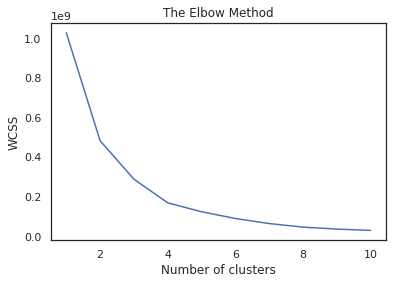

In [157]:
# Utilizo el 'Elbow method'  para seleccionar el número óptimo de clusters.
'''
Este método emplea la suma de las distancias al cuadrado de cada objeto del Cluster a su centroide.
De esta manera determina cual es el número óptimo de centroides.
EL resultado es una muestra lineal cuyo 'codo' nos indica el nº de clusters óptimos para la muestra.
wcss = Within Clusters Summed Squares
'''

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Grafica de la suma de las distancias
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Esta gráfica nos indica que el número óptimo de clusters es 3.

In [158]:
# Creando el algoritmo k-Means para los 3 grupos encontrados
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)

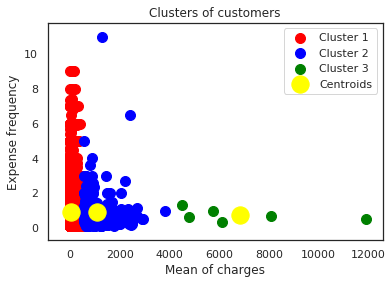

In [159]:
# Visualizacion gráfica de los clusters
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')


plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Centroids')

plt.title('Clusters of customers')
plt.xlabel('Mean of charges')
plt.ylabel('Expense frequency')
plt.legend()
plt.show()

Como podemos ver en el gráfico, hemos clasificado a los clientes en 3 clusters distintos, donde el punto amarillo indica el centroide de cada uno de ellos.

- El cluster nº 1 nos agrupa aquellos clientes que realizan muchas compras diarias pero de pequeños importes. Si    observamos la gráfica, la cantidad gastada de este cluster va de 0€ hasta los 500 €, sin embargo la mayoría de los valores están más próximos al 0 que al 500. Además los clientes de este clúster puede realizar hasta 9 compras diarias.  lo que supone una gran parte de los clientes de Bnext.

- El cluster nº2 es el más importante. Es el clúster más numeroso y representa a todos los clientes que realizan varias compras diarias cuya cantidad siempre es igual o superior a los 500€. Este cluster es de suma importancia ya que representa a la gran parte de clientes de Bnext. Observamos que la mayoria de los clientes realizan entre 0 y 3 compras diarias con cantidades que oscilan entre los 500 y 1200€. 

- El cluster nº3 es el más reducido. Se trata de aquellos clientes que realizan entre 0 y 2 compras diarias pero gastan cantidades muy altas de dinero. 

# Pregunta nº 2

PREGUNTA 2: Te pregunta el CEO que no entiende la evolución de los datos en el periodo escogido, que le parece algo anómala. ¿Encuentras algún patrón que permita encontrar outliers? Esta es una pregunta abierta, puedes analizar los datos de la manera que quieras.

In [160]:
#Primero analizamos la evolución de las compras
purchases = data[data.category == 'Purchase']

In [161]:
# Agrupamos las cantidades compradas por fechas
purchases = pd.pivot_table(purchases, index = ['date'], values = 'amount', aggfunc = ({'amount': 'sum'})) 
purchases.reset_index(inplace = True)
purchases.head()

,date,amount
0,2018-11-20,317942.850
1,2018-11-21,367355.200
2,2018-11-22,445351.925
3,2018-11-23,1470355.275
4,2018-11-24,588330.775


In [162]:
#Visualizamos la evolución de las compras en el tiempo.
purchases.iplot(kind='line', x='date', xTitle='Time', color='blue',
           yTitle='purchases', title='Purchases Evolution')

En esta gráfica observamos como el 23 de noviembre hay un pico muy alto que sobresale por encima de la evolución normal de los gastos (!Casi alcanza el millón y medio de compras¡). Esto se debe a que el 23/11/2018 fué el Black Friday, y como todos sabemos es el día de más consumo en el año. Además, el Black Friday es un día donde las compras online son mucho mayores, lo que favorece al perfil de cliente de Bnext, que por lo que tengo entendido, muchos de ellos se caracterizan por utilizar su tarjeta Bnext para compras online.
También podemos apreciar una caída de las compras entre el 30/11 y el 01/12 que se debe a la falta de datos para el primer día de enero, ya que solo disponemos de datos hasta las 8 de la mañana.


In [163]:
#Analizamos la evolución de los ingresos
income = data[data.category == 'Topup TPV']

In [164]:
# Agrupamos las cantidades ingresadas por fechas
income = pd.pivot_table(income, index = ['date'], values = 'amount', aggfunc = ({'amount': 'sum'})) 
income.reset_index(inplace = True)
income.head()

,date,amount
0,2018-11-20,645554.375
1,2018-11-21,787869.775
2,2018-11-22,1000562.775
3,2018-11-23,1806325.350
4,2018-11-24,859111.750


In [165]:
#Visualizamos la evolución de los ingresos en el tiempo.
income.iplot(kind='line', x='date', xTitle='Time', color='blue',
           yTitle='Income', title='Income Evolution')

En esta gráfica que representa la evolución de los ingresos, vemos como existe un pico muy parecido al de los gastos el día del Black Friday. Este outlier es muy probable que sea gracias a las promociones disponibles en el marketplace de Bnext, las cuales incitan a que el cliente ingrese dinero en la cuenta Bnext para aprovechar los descuentos/promociones disponibles de vuestros partners.
También observamos como a final de mes la evolución de los ingresos va creciendo. La justificación más lógica es que esas fechas coinciden con el periodo en el que los clientes cobran su sueldo. 
Sin embargo vemos como entre el día 30/11/2018 y el día 1/12/2018 los ingresos se desploman, pero esto no es significativo ya que del primer día de diciembre solo tenemos datos hasta las 8 de las mañana. De hecho me aventuraría a decir, que si tuviesemos los datos de los primeros días de enero podríamos ver como la evolución sigue siendo positiva por lo menos hasta el día 10/01(sigue siendo periodo de pago de salarios). 

In [166]:
#Analizamos la evolución de los ingresos
transfers = data[data.category == 'Bnext Send Money']

In [167]:
# Agrupamos las cantidades transpasadas por fechas
transfers = pd.pivot_table(transfers, index = ['date'], values = 'amount', aggfunc = ({'amount': 'sum'})) 
transfers.reset_index(inplace = True)
transfers.head()

,date,amount
0,2018-11-20,119722.375
1,2018-11-21,141931.050
2,2018-11-22,252498.975
3,2018-11-23,241472.150
4,2018-11-24,192534.425


In [168]:
#Visualizamos la evolución de las transferencias en el tiempo.

transfers.iplot(kind='line', x='date', xTitle='Time', color='blue',
           yTitle='Bnext Send Money', title='Bnext Send Money Evolution')

El análisis de las transferencias entre clientes de Bnext creo que lo voy a quitar

# Pregunta nº 3

PREGUNTA 3 (opcional): Busca el concepto de cohorte si no estás familiarizadx con él, y realiza un análisis de cohortes diarias. Puedes considerar que la primera transacción de cada usuario en la muestra fue su primera transacción en Bnext.

In [169]:
# Calculo el número de operaciones por cliente (compras, envíos de dinero e ingresos) 
operations = pd.pivot_table (data, index = ['user_id'], values = ['amount'], aggfunc = ({'amount':'count'}))
operations = operations.sort_values('amount', ascending = False)
operations.rename(columns = {'amount':'Nº operations'}, inplace = True)
operations.head()

,Nº operations
user_id,
qsqbs-ylycl-titji,251
bbqij-ccygr-jjtxg,87
aiqqi-mgyyg-yxttx,81
avo-mzu-ypq,79
vocqa-zuaym-pqhty,72


In [170]:
#Mergeo las tablas para tener todos los datos agrupados
data = pd.merge(data, operations, on ='user_id')
data.head()

,user_id,amount,category,date,Nº operations
0,jcbvas-raczml-ghjpyi,7.500,Purchase,2018-12-01,8
1,jcbvas-raczml-ghjpyi,18.125,Purchase,2018-12-01,8
2,jcbvas-raczml-ghjpyi,17.500,Purchase,2018-12-01,8
3,jcbvas-raczml-ghjpyi,8.750,Purchase,2018-12-01,8
4,jcbvas-raczml-ghjpyi,8.750,Purchase,2018-12-01,8


In [171]:
'''
Creo una columna nueva donde clasifico a cada uno de los clientes por un grupo de cohorte.
El grupo de cohorte de cada cliente corresponde a la fecha de la primera operación registrada.
Esta fecha se toma como si fuera la primera transacción del usuario en la app de Bnext
Como
'''
data.set_index('user_id', inplace = True)
data['CohortGroup']  = data.groupby(level = 0)['date'].min()
data.reset_index(inplace = True)
data.head()

,user_id,amount,category,date,Nº operations,CohortGroup
0,jcbvas-raczml-ghjpyi,7.500,Purchase,2018-12-01,8,2018-11-22
1,jcbvas-raczml-ghjpyi,18.125,Purchase,2018-12-01,8,2018-11-22
2,jcbvas-raczml-ghjpyi,17.500,Purchase,2018-12-01,8,2018-11-22
3,jcbvas-raczml-ghjpyi,8.750,Purchase,2018-12-01,8,2018-11-22
4,jcbvas-raczml-ghjpyi,8.750,Purchase,2018-12-01,8,2018-11-22


In [172]:
'''
Agrupo por grupo de cohorte y fecha, de tal manera que por cada grupo de cohorte podemos ver el número de días
en los que se han realizado transacciones
'''
cohortes = pd.pivot_table(data, index = ['CohortGroup','date'], values = ['amount','Nº operations','user_id'], aggfunc = ({'amount':sum, 'Nº operations':pd.Series.nunique, 'user_id': pd.Series.nunique }))
cohortes.rename(columns = {'user_id':'Total Users', 'Nº operations':'Total Operations', 'amount':'Total Amount'}, inplace = True)
cohortes.head()

Total Operations  Total Amount  Total Users
CohortGroup date                                                   
2018-11-20  2018-11-20                56   1083219.600         6408
            2018-11-21                54    320886.775         1573
            2018-11-22                52    345969.375         2075
            2018-11-23                55    668907.075         2467
            2018-11-24                54    330199.650         1577

In [173]:
'''
Queremos ver cómo se ha comportado cada cohorte en los días posteriores a su primera compra, 
por lo vamos indexar cada cohorte a su primer día de compra. El día 1 de cada cohorte será el periodo de cohorte 1,
el día 2 de cada cohorte será el periodo de cohorte 2 y asi sucesivamente. Por el ejemplo si estamos en el cohorte 
del 25/11/2018 el segundo periodo de ese cohorte será el 26/11/2018, mientras que si estamos en el cohorte del 
28/11/2018 el segundo periodo de ese cohorte será el 29/11/2018.
Para ello creamos la funcion cohort_period.
'''

def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [174]:
# Aplico la función al dataset agrupado.
cohortes = cohortes.groupby(level=0).apply(cohort_period)
cohortes.head()

Total Operations  Total Amount  Total Users  \
CohortGroup date                                                      
2018-11-20  2018-11-20                56   1083219.600         6408   
            2018-11-21                54    320886.775         1573   
            2018-11-22                52    345969.375         2075   
            2018-11-23                55    668907.075         2467   
            2018-11-24                54    330199.650         1577   

                        CohortPeriod  
CohortGroup date                      
2018-11-20  2018-11-20             1  
            2018-11-21             2  
            2018-11-22             3  
            2018-11-23             4  
            2018-11-24             5

In [175]:
# Agrupo la tabla por grupo de cohorte y periodo de cohorte
cohortes.reset_index(inplace=True)
cohortes.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
cohortes.head()

date  Total Operations  Total Amount  \
CohortGroup CohortPeriod                                               
2018-11-20  1             2018-11-20                56   1083219.600   
            2             2018-11-21                54    320886.775   
            3             2018-11-22                52    345969.375   
            4             2018-11-23                55    668907.075   
            5             2018-11-24                54    330199.650   

                          Total Users  
CohortGroup CohortPeriod               
2018-11-20  1                    6408  
            2                    1573  
            3                    2075  
            4                    2467  
            5                    1577

In [176]:
# Creo una serie con el número total de usuarios para cada cohorte
cohort_group_size = cohortes['Total Users'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2018-11-20    6408
2018-11-21    4702
2018-11-22    6167
2018-11-23    7411
2018-11-24    2949
Name: Total Users, dtype: int64

In [177]:
'''
Ahora creamos una matriz para distribuir a los usuarios, donde las columnas serán el grupo de cohortes 
y las filas serán el periodo de cohorte . De esta manera podremos ver podremos ver la evolución de los usuarios en 
los días posteriores a su primera transacción con Bnext.
'''

cohortes['Total Users'].unstack(0)

CohortGroup,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01
CohortPeriod,,,,,,,,,,,,
1,6408.0,4702.0,6167.0,7411.0,2949.0,2186.0,2171.0,1828.0,1650.0,1532.0,1703.0,136.0
2,1573.0,1187.0,2003.0,1533.0,448.0,286.0,301.0,218.0,228.0,236.0,42.0,NaN
3,2075.0,1663.0,1090.0,1019.0,386.0,355.0,285.0,190.0,209.0,29.0,NaN,NaN
4,2467.0,1037.0,879.0,1040.0,472.0,304.0,258.0,349.0,25.0,NaN,NaN,NaN
5,1577.0,776.0,1046.0,1164.0,421.0,271.0,365.0,26.0,NaN,NaN,NaN,NaN
6,1248.0,979.0,1077.0,1791.0,342.0,462.0,40.0,NaN,NaN,NaN,NaN,NaN
7,1619.0,886.0,1271.0,1627.0,598.0,46.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1516.0,1053.0,1164.0,1637.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1745.0,955.0,2214.0,154.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [178]:
'''
Ahora vamos a crear un dataFrame llamado user_retention (retencion de usuarios),que contiene el porcentaje de
usuarios de la cohorte que compra dentro del período dado. Por ejemplo: El 17,67% de los usuarios que hicieron 
su primera transacción el 22/11/2018 volvieron a comprar el 24/11/2018.
El periodo 1 de cohorte como siempre coincide con el día del grupo de cohorte siempre va a ser el 100%.
'''

user_retention = cohortes['Total Users'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(10)

CohortGroup,2018-11-20,2018-11-21,2018-11-22,2018-11-23,2018-11-24,2018-11-25,2018-11-26,2018-11-27,2018-11-28,2018-11-29,2018-11-30,2018-12-01
CohortPeriod,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.245474,0.252446,0.324793,0.206855,0.151916,0.130833,0.138646,0.119256,0.138182,0.154047,0.024662,NaN
3,0.323814,0.353679,0.176747,0.137498,0.130892,0.162397,0.131276,0.103939,0.126667,0.018930,NaN,NaN
4,0.384988,0.220544,0.142533,0.140332,0.160054,0.139067,0.118839,0.190919,0.015152,NaN,NaN,NaN
5,0.246099,0.165036,0.169612,0.157064,0.142760,0.123971,0.168125,0.014223,NaN,NaN,NaN,NaN
6,0.194757,0.208209,0.174639,0.241668,0.115972,0.211345,0.018425,NaN,NaN,NaN,NaN,NaN
7,0.252653,0.188430,0.206097,0.219539,0.202781,0.021043,NaN,NaN,NaN,NaN,NaN,NaN
8,0.236579,0.223947,0.188747,0.220888,0.021024,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.272316,0.203105,0.359008,0.020780,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
user_retention[['2018-11-20' , '2018-11-21' , '2018-11-22' , '2018-11-23' , '2018-11-24' , '2018-11-25' , '2018-11-26' , '2018-11-27' , '2018-11-28' , '2018-11-29' , '2018-11-30' , '2018-12-01']].plot(figsize=(10,5))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 12.1, 1))
plt.xlim(1, 12)
plt.ylabel('% of Cohort Purchasing');

KeyError: "None of [Index(['2018-11-20', '2018-11-21', '2018-11-22', '2018-11-23', '2018-11-24',\n       '2018-11-25', '2018-11-26', '2018-11-27', '2018-11-28', '2018-11-29',\n       '2018-11-30', '2018-12-01'],\n      dtype='object', name='CohortGroup')] are in the [columns]"

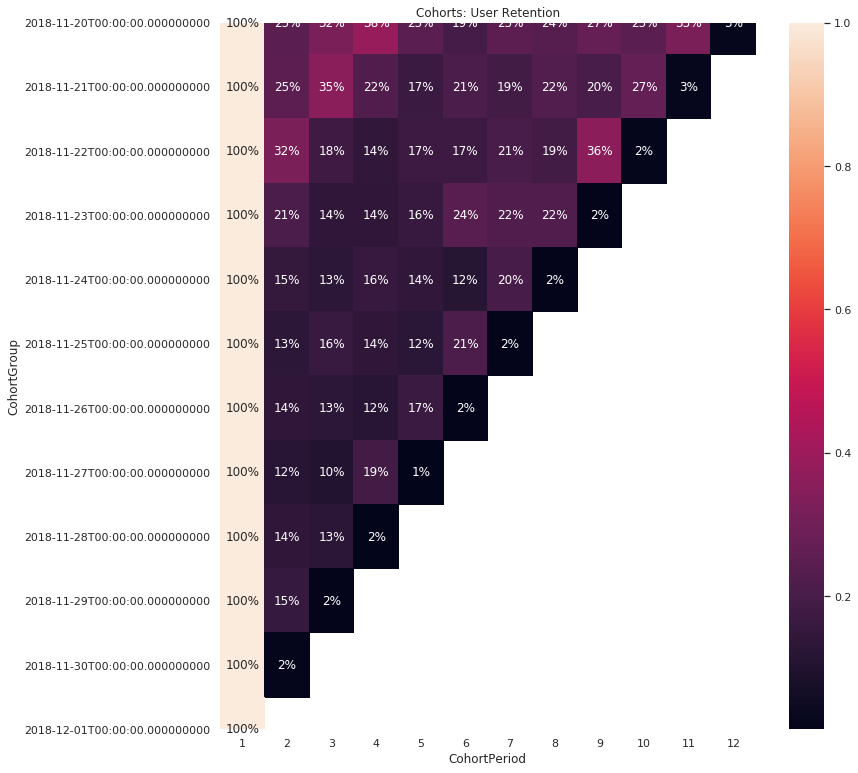

In [180]:
#Representamos con un mapa de calor la retención de clientes a lo largo de este periodo.
sns.set(style='white')

plt.figure(figsize=(12, 13))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

En este gráfico podemos ver que los usuarios tienden a comprar menos a medida que pasa el tiempo.

Sin embargo, también podemos ver que los dos primeros cohortes son los más fuertes (20/11/2018 y 21/11/2018), lo que hace preguntarnos que atributos comunes en estos usuarios podrían estar causando una mayor implicación con la app de Bnext respecto al resto. Esto puede deberse a diversos factores, como el método de captación de usuarios, la campaña de marketing que se utilizo, una promoción de registro...